In [63]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.scipy.special import logsumexp
import jax
import numpy as np

In [2]:
# Code some functions to help with the neural network
def random_layer_params(m, n, key, scale=1e-2):
    """
    Initialise the weights for a layer of a neural network.

    Args:
    m: int, the number of input units
    n: int, the number of output units
    key: PRNGKey, a key for random number generation
    scale: float, a scaling factor for the weights

    Returns:
    w: array of shape (n, m), the weights
    b: array of shape (n,), the biases

    """
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(sizes, key):
    """
    Initialise the weights for a neural network.

    Args:
    sizes: list of int, the number of units in each layer
    key: PRNGKey, a key for random number generation

    Returns:
    a list of tuples, each tuple containing the weights and biases for a layer

    """
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

# Define some parameters for the neural network
layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 10
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.key(0))

In [12]:
# Define some more useful functions

def relu(x):
    """
    Rectified linear unit activation function.

    Args:
    x: array, the input to the activation function

    Returns:
    array, the output

    """
    return jnp.maximum(0, x)

def predict(params, image):
    """
    Make predictions for the label given the parameters and image.

    Args:
    params: list of tuples, the weights and biases for each layer
    image: array of shape (784,), the input image

    Returns:
    array of shape (10,), the predicted label
    """

    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits) #Returns softmax function

In [13]:
random_flattened_image = random.normal(random.key(1), (784,))
preds = predict(params, random_flattened_image)
print(preds)

[-2.2909994 -2.2938476 -2.2901456 -2.3175743 -2.3124409 -2.3007157
 -2.302447  -2.3278596 -2.2889743 -2.301602 ]


In [14]:
random_flattened_images = random.normal(random.key(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [15]:
batched_predict = vmap(predict, in_axes=(None, 0))

batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(10, 10)


In [20]:
# Making some utility functions to help with the training

def one_hot(x, k, dtype=jnp.float32):
    """
    Create a one-hot encoding of x of size k.
    """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

def accuracy(params, images, targets):
    """
    Calculate the accuracy of the network.

    Args:
    params: list of tuples, the weights and biases for each layer
    images: array of shape (n, 784), the input images
    targets: array of shape (n,), the target labels

    Returns:
    float, the accuracy of the network
    """
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
    """
    Calculates the loss of the network.
    """

    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
    """
    Update the parameters of the network.
    """
    grads = grad(loss)(params, x, y)
    return [(w - step_size * dw, b - step_size * db)
            for (w, b), (dw, db) in zip(params, grads)]

In [29]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [30]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


In [31]:
import time

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 5.39 sec
Training set accuracy 0.957966685295105
Test set accuracy 0.9530999660491943
Epoch 1 in 4.52 sec
Training set accuracy 0.9690666794776917
Test set accuracy 0.9615999460220337
Epoch 2 in 5.51 sec
Training set accuracy 0.9722499847412109
Test set accuracy 0.9627999663352966
Epoch 3 in 5.28 sec
Training set accuracy 0.9754666686058044
Test set accuracy 0.9656999707221985
Epoch 4 in 4.51 sec
Training set accuracy 0.97843337059021
Test set accuracy 0.9674999713897705
Epoch 5 in 4.76 sec
Training set accuracy 0.9801000356674194
Test set accuracy 0.9681999683380127
Epoch 6 in 4.58 sec
Training set accuracy 0.9815000295639038
Test set accuracy 0.9682999849319458
Epoch 7 in 4.66 sec
Training set accuracy 0.9829333424568176
Test set accuracy 0.9696999788284302
Epoch 8 in 4.36 sec
Training set accuracy 0.9849500060081482
Test set accuracy 0.9700999855995178
Epoch 9 in 4.44 sec
Training set accuracy 0.986383318901062
Test set accuracy 0.9711999893188477


In [38]:
# Now try making an NN using the stax submodule

import jax.numpy as jnp
from jax import random, grad, vmap, jit, pmap, value_and_grad
from jax.example_libraries.stax import Dense, Relu, LogSoftmax, BatchNorm, Dropout
from jax.example_libraries import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [45]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Use dictionary of class labels
labels_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}



In [46]:
# Define some utility functions

def plot_samples(x, y, figsize=(12,8), num_rows=5, num_columns=3, title=None):
    if len(x) != len(y):
        raise ValueError('x and y must have the same length')
    
    fig, axes = plt.subplots(num_rows, num_columns, figsize=figsize)
    for i in range(num_rows*num_columns):
        try:
            img = x[i]
            label = str(y[i])
            row = i // num_columns
            col = i % num_columns
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
            axes[row, col].set_title(label)
        except:
            pass
    
    if title:
        plt.suptitle(title)
    plt.show()


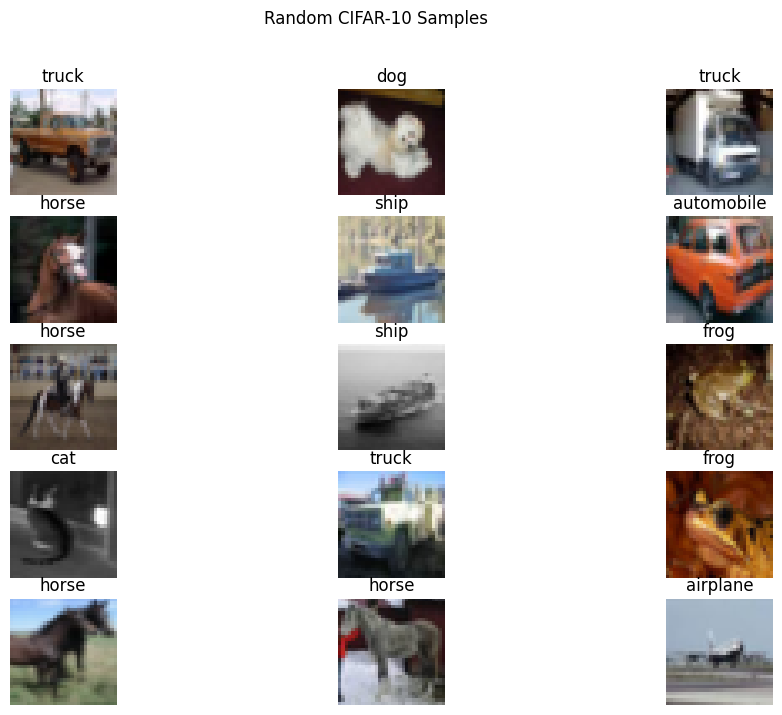

In [47]:
# Select some random samples to plot

num_samples = 15
indices = jnp.arange(len(x_train))
random_indices = random.choice(random.key(0), indices, shape=(num_samples,), replace=False)

random_x = x_train[random_indices]
random_y = y_train[random_indices]
random_labels = [labels_dict[label[0]] for label in random_y]

plot_samples(random_x, random_labels, title='Random CIFAR-10 Samples')

In [54]:
# Define some transformations to images

def rotate_90(img):
    return jnp.rot90(img, k=1, axes=(0,1))

def identity(img):
    return img

def flip_left_right(img):
    return jnp.fliplr(img)

def flip_up_down(img):
    return jnp.flipud(img)

def random_rotate(img, rotate):
    return jax.lax.cond(rotate, rotate_90, identity, img)

def random_horizontal_flip(img, flip):
    return jax.lax.cond(flip, flip_left_right, identity, img)

def random_vertical_flip(img, flip):
    return jax.lax.cond(flip, flip_up_down, identity, img)


# Use vmap and jit to improve functions
random_rotate_jitted = jit(vmap(random_rotate, in_axes=(0, 0)))
random_horizontal_flip_jitted = jit(vmap(random_horizontal_flip, in_axes=(0, 0)))
random_vertical_flip_jitted = jit(vmap(random_vertical_flip, in_axes=(0, 0)))


def augment_images(images, key):
    batch_size = len(images)

    # Rotate
    key, subkey = random.split(key)
    rotate = random.randint(key, shape=(batch_size,), minval=0, maxval=2)
    augmented = random_rotate_jitted(images, rotate)

    # Horizontal flip
    key, subkey = random.split(key)
    flip = random.randint(key, shape=(batch_size,), minval=0, maxval=2)
    augmented = random_horizontal_flip_jitted(augmented, flip)

    # Vertical flip
    key, subkey = random.split(key)
    flip = random.randint(key, shape=(batch_size,), minval=0, maxval=2)
    augmented = random_vertical_flip_jitted(augmented, flip)  

    return augmented

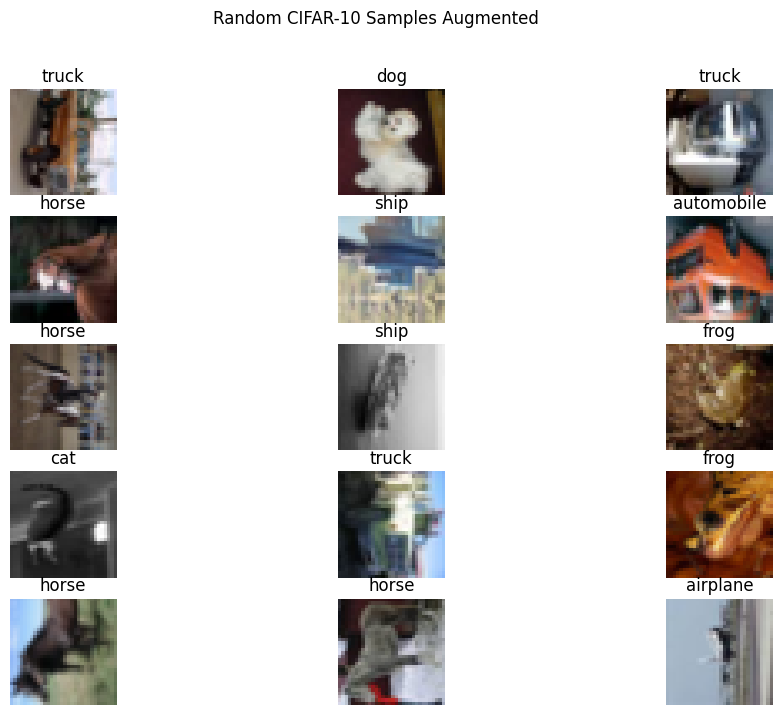

In [55]:
randomly_selected_images_augmented = augment_images(random_x, random.key(0))

plot_samples(randomly_selected_images_augmented, random_labels, title='Random CIFAR-10 Samples Augmented')

In [57]:
# One-hot encode the labels
y_train = jnp.squeeze(jax.nn.one_hot(y_train, num_classes=10))
y_test = jnp.squeeze(jax.nn.one_hot(y_test, num_classes=10))

print(f"Training images shape:   {x_train.shape}  Labels shape: {y_train.shape}")
print(f"Validation images shape: {x_test.shape}  Labels shape: {y_test.shape}")


Training images shape:   (50000, 32, 32, 3)  Labels shape: (50000, 10, 10)
Validation images shape: (10000, 32, 32, 3)  Labels shape: (10000, 10, 10)


In [68]:
# Generate batches of data

def data_generator(images, labels, batch_size=128, is_valid=False, key=None):
    num_batches = int(jnp.ceil(len(images) / batch_size))

    indices = jnp.arange(len(images))

    if not is_valid:
        if key is None:
            raise ValueError('A key must be provided for training data')
        else:
            np.random.shuffle(indices)

    for batch in range(num_batches):
        curr_idx = indices[batch * batch_size : (batch + 1) * batch_size]
        batch_images = images[curr_idx]
        batch_labels = labels[curr_idx]

        if not is_valid:
            batch_images = augment_images(batch_images, key=key)
        yield batch_images, batch_labels

In [69]:
sample_data_gen = data_generator(
    images=x_train,
    labels=y_train,
    batch_size=8,
    is_valid=False,
    key=random.key(0)
)

sample_batch_images, sample_batch_labels = next(sample_data_gen)
print("Batch of images is of shape: ", sample_batch_images.shape)
print("Batch of labels is of shape: ", sample_batch_labels.shape)

# Clean up unnecessary objects
del sample_data_gen, sample_batch_images, sample_batch_labels

C:\Users\thoma\AppData\Local\Temp\ipykernel_22824\3088216208.py:12: UserWarning: you are shuffling a 'ArrayImpl' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(indices)


TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html